# Titanic: Machine Learning from Disaster



## Introduction

This is an experiment with [kaggle Titanic machine learning for disaster](https://www.kaggle.com/c/titanic) problem. First I will try to visualize the data to get a better intution about the data. Then by using various machine learning model I will try to predict the survival of passenger on the test data.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer # to be used for dealing with NaN values in the data
from sklearn.preprocessing import LabelEncoder,OneHotEncoder # for categorical data
%matplotlib inline

In [2]:
# loading traing and test data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Intial data exploration

There is a couple of features which I am going to drop such as passengerId, Name etc.

In [4]:
drop_features = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_data.drop(drop_features, axis=1, inplace=True)
test_data.drop(drop_features, axis=1, inplace=True)
train_data.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Now let's quickly draw some figures to get a deeper insight of the data

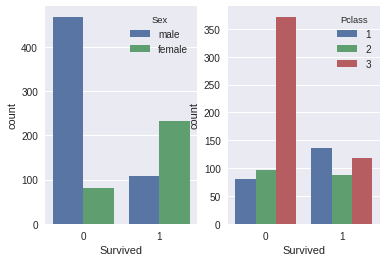

In [5]:
fig, ax =plt.subplots(1,2)
sns.countplot(x='Survived',hue='Sex', data=train_data, ax=ax[0])
sns.countplot(x='Survived',hue='Pclass', data=train_data, ax=ax[1])

Now let's try to get some more intution about the problem through the plots

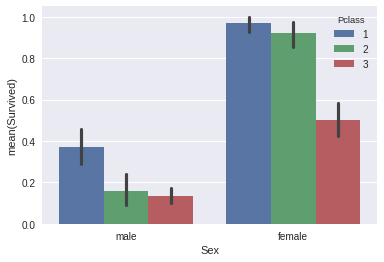

In [6]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_data)

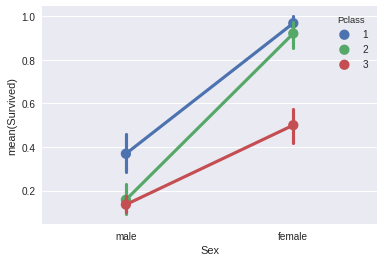

In [7]:
sns.pointplot(x='Sex', y='Survived', hue='Pclass', data=train_data)

Clearly The survival rate of First and Second class female passenger is alomost 100 percent.

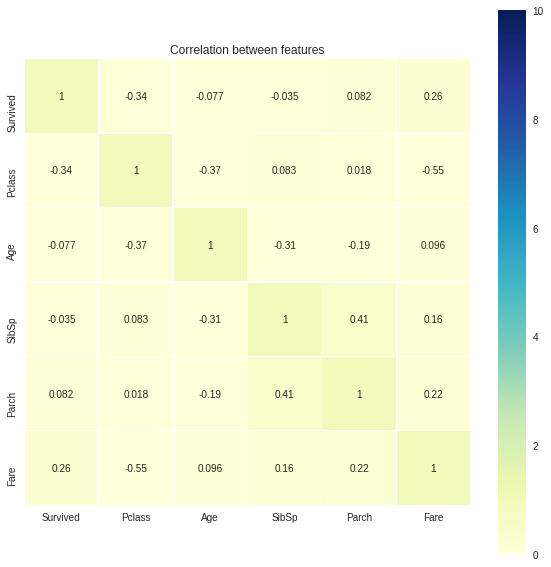

In [8]:
corr=train_data.corr()#["Survived"]
plt.figure(figsize=(10, 10))

sns.heatmap(corr, vmax=10, vmin=0, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features');

All right now let us preprocess the data before we feed it into our model

## Data preprocessing


In [9]:
# checking for missing data
train_data.isnull().any()

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
Embarked     True
dtype: bool

In [10]:
train_data['Embarked'].fillna(train_data['Embarked'].value_counts().index[0], inplace=True)
X = train_data.iloc[:, 1:].values
y = train_data.iloc[:, 0:1].values

# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, 2:6])
X[:, 2:6] = imputer.transform(X[:, 2:6])

# encoding categorical features
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
labelencoder_X = LabelEncoder()
X[:, 1] = labelencoder_X.fit_transform(X[:, 1])
X[:, 6] = labelencoder_X.fit_transform(X[:, 6])
onehotencoder = OneHotEncoder(categorical_features=[1, 6])
X = onehotencoder.fit_transform(X).toarray()

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

## Build model

Now that our data is ready we can finally focus onto building up machine learning model

### 1. SVM

In [11]:
# selecting SVC model
from sklearn.svm import SVC
#model.fit(X_trai n, y_train)
# Applying Grid Search to find the best model and the best parameters
from sklearn.model_selection import GridSearchCV
parameters = [{'C': [1,10,100,1000], 'kernel': ['linear']},
              {'C': [1,10,100,1000], 'kernel': ['rbf'], 'gamma': np.arange(0.1, 0.9, 0.02)}]
grid_search = GridSearchCV(estimator=SVC(),
                           param_grid=parameters,
                           scoring='accuracy',
                           cv=10,
                           n_jobs=-1)
c,l=y_train.shape
grid_search.fit(X_train, y_train.reshape(c,))
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_accuracy)
print(best_parameters)

0.832335329341
{'C': 1, 'gamma': 0.16000000000000003, 'kernel': 'rbf'}


All right so now fit SVM model with these hyperparameters 

In [ ]:
svc_model = SVC(C=1, gamma=0.10000000000000001, kernel='rbf', random_state=0)
svc_model.fit(X_train, y_train)